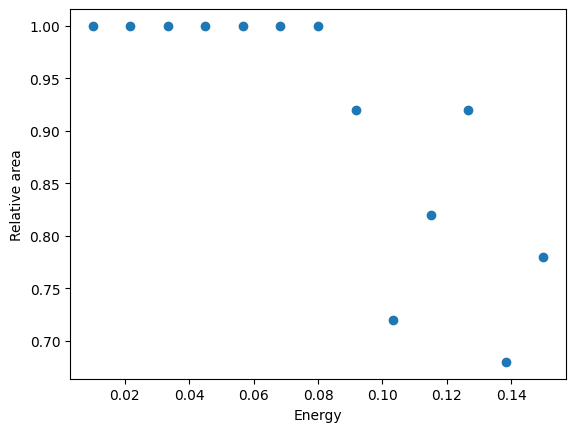

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from Potentiel import *
from RK4 import *
from RK2 import *
from Euler import *
import random


def Chaos_HenonHeiles(h, liste_poincarres,  N, Pot=Henon_Heiles, muc= 1e-4, Method=RK4, ntraj = 300) : 

    # energy values for which we will compute the trajectory
    E_values= np.linspace(0.01, 0.17, 15)

    # relative area occupied by the curve in Poincare section
    relative_area= np.zeros(len(E_values))


    for k in range(len(E_values)) : 
        E= E_values[k]
        nb_curve = 0

        for n in range(ntraj) :
            # we need to count the number of points in the Poincare section for each trajectory
            count1= 0  
            count2= 0

            mu= 0.
            b = 0
            # to check that the initial condition will work before computing a trajectory
            while (b==0) : 
                yi1 = random.uniform(-0.4,0.4)
                vi1 = random.uniform(-0.4,0.4)

                # second initial point at a distance 1e-8
                yi2= yi1 - np.sqrt(0.5*1e-8)
                vi2= vi1 - np.sqrt(0.5*1e-8)

                if (2*(E-Pot(0,yi1))-vi1**2 > 0) & (2*(E-Pot(0,yi2))-vi2**2 > 0) :
                    b = 1

            
            y1_list = np.array([])
            v1_list = np.array([])

            y2_list = np.array([])
            v2_list = np.array([])

            u1= np.sqrt(2*(E-Pot(0,yi1))-vi1**2)        
            wn1= np.array([0,yi1,u1,vi1])

            u2= np.sqrt(2*(E-Pot(0,yi2))-vi2**2)        
            wn2= np.array([0,yi2,u2,vi2])

            # computation of the trajectory and Poincare section
            wn1_moins1 = wn1 
            wn2_moins1 = wn2


            for i in range(N) : 

                # first trajectory
                while(count1<20) : 
                    if np.sign(wn1_moins1[0]) != np.sign(wn1[0]) :

                        count1= count1+1

                        # Interpolation linéaire

                        y01 = wn1_moins1[1] - wn1_moins1[0] * (wn1[1] - wn1_moins1[1]) / (wn1[0] - wn1_moins1[0])
                        v01 = wn1_moins1[3] - wn1_moins1[0] * (wn1[3] - wn1_moins1[3]) / (wn1[0] - wn1_moins1[0])

                        y1_list = np.append(y1_list,y01)
                        v1_list = np.append(v1_list,v01)

                    wn1_moins1 = wn1
                    wn1 = Method(wn1, f, h, Pot)

                # second trajectory
                while(count2<20) :
                    if np.sign(wn2_moins1[0]) != np.sign(wn2[0]) :

                        count2= count2+1

                        # Interpolation linéaire

                        y02 = wn2_moins1[1] - wn2_moins1[0] * (wn2[1] - wn2_moins1[1]) / (wn2[0] - wn2_moins1[0])
                        v02 = wn2_moins1[3] - wn2_moins1[0] * (wn2[3] - wn2_moins1[3]) / (wn2[0] - wn2_moins1[0])

                        y2_list = np.append(y2_list,y02)
                        v2_list = np.append(v2_list,v02)


                    wn2_moins1 = wn2
                    wn2 = Method(wn2, f, h, Pot)

            # we compute the mu value 
            for j in range(len(y1_list)) :
                mu= mu + (y1_list[j] - y2_list[j])**2 + (v1_list[j] - v2_list[j])**2

            # we check if the trajectory is a curve or ergodic according to mu value
            if mu<muc : 
                nb_curve= nb_curve + 1
                #print(mu)
        
        # we compute the relative area occupied by the curves 
        relative_area[k]= nb_curve/ntraj


    plt.figure()

    plt.scatter(E_values, relative_area)
    plt.xlabel('Energy')
    plt.ylabel('Relative area')

    plt.show()


    return


# ---------------------------------------------------------------------


def Orbite(wn, N, h, Methode, pot) :
    
    Trajectoire = np.zeros((4,N))

    for i in range(N) : 
        Trajectoire[:,i] = wn
        wn = Methode(wn, f, h,pot)

    return Trajectoire



def Lin_Regression(X,Y) :
    linear_regressor = LinearRegression(fit_intercept=True)
    result = linear_regressor.fit(X, Y)

    return result.coef_[0], result.intercept_


def Gottwald_Melbourne_v1(wn, N, h) :
    Trajectoire = np.zeros((4,N))
    p= np.zeros(N)
    M= np.zeros(N)
    #p_mt= np.zeros(N)
    theta= np.zeros(N)

    t= np.linspace(0, N*h, N)
    c= 1.7

    Trajectoire[:,0]= wn
    wn = RK4(wn, f, h, Henon_Heiles)

    for ntau in range(1,N) : 

        Trajectoire[:,ntau] = wn
        wn = RK4(wn, f, h, Henon_Heiles)
        #print(wn)

        x= Trajectoire[0, 0:ntau+1]
        s= ntau*h

        theta[ntau]= c*s + h*sum(x)
        p[ntau] = h*sum(x*np.cos(theta[0:ntau+1]))
        #p_mt[ntau] = p[ntau-1]
        M[ntau]= (p[ntau]-p[0])**2

    Mmean= sum(M)/(N*h)
    K= np.log(Mmean+1)/np.log(N*h)

    return K



def Gottwald_Melbourne_v2(wn, N, h) :
    Trajectoire = np.zeros((4,N))
    p= np.zeros(N)
    #p_mt= np.zeros(N)
    theta= np.zeros(N)
    M= np.zeros(N)
    tau= np.zeros(N)
    K= np.zeros(N)

    #t= np.linspace(0, N*h, N)
    c= 1.7

    Trajectoire[:,0]= wn
    wn = RK4(wn, f, h, Henon_Heiles)

    for ntau in range(1,N) : 

        Trajectoire[:,ntau] = wn
        wn = RK4(wn, f, h, Henon_Heiles)
        #print(wn)

        x= Trajectoire[0, 0:ntau+1]
        s= ntau*h

        theta[ntau]= c*s + h*sum(x)
        p[ntau] = h*sum(x*np.cos(theta[0:ntau+1]))
        #p_mt[ntau] = p[ntau-1]

    for ntau in range(1,N) : 
        for nt in range(0,N-ntau) :
            M[ntau]= M[ntau] + (p[nt+ntau]-p[nt])**2
        M[ntau]= M[ntau]/(h*(N-ntau))    
        tau[ntau]= ntau*h
        #print(M[ntau])
    
    tau= tau.reshape(-1,1)
    K, b= Lin_Regression(np.log(tau+1e-7), np.log(M+1))

    """plt.figure()
    plt.scatter(np.log(tau), np.log(M+1))
    plt.show()"""

    return K

def Chaos_Gottwald_Melbourne(N, h, ntraj=300) :
    # energy values for which we will compute the trajectory
    E_values= np.linspace(0.01, 0.15, 13)

    # relative area occupied by the curve in Poincare section
    relative_area= np.zeros(len(E_values))


    for k in range(len(E_values)) : 
        E= E_values[k]
        nb_curve = 0
        e= 0.5

        for n in range(ntraj) :
            b = 0
            # to check that the initial condition will work before computing a trajectory
            while (b==0) : 
                yi = random.uniform(-0.4,0.4)
                vi = random.uniform(-0.4,0.4)

                if (2*(E-Henon_Heiles(0,yi))-vi**2 > 0)  :
                    b = 1

            ui= np.sqrt(2*(E-Henon_Heiles(0,yi))-vi**2)        
            wn= np.array([0,yi,ui,vi])

            K= Gottwald_Melbourne_v2(wn, N, h)
            if K<e :
                nb_curve= nb_curve + 1
                #print(nb_curve)


        # we compute the relative area occupied by the curves 
        relative_area[k]= nb_curve/ntraj

    plt.figure()

    plt.scatter(E_values, relative_area)
    plt.xlabel('Energy')
    plt.ylabel('Relative area')

    plt.show()


    return
            


wn = np.array([0,0.1,0.157,0.1])
N = 1000
h = 10.**-1

#Gottwald_Melbourne_v2(wn, N, h)
Chaos_Gottwald_Melbourne(N, h, 50)